In [1]:
import math
import scipy.integrate
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from mpmath import *
mp.pretty= True
mp.dps=20

#from sympy.solvers import solve
#from sympy import Symbol
#from scipy.special import logsumexp
import random

In [3]:
import os
os.getcwd()

'/Users/waltertangarife/Dropbox/MyUdeAprojects/DarkBaryogenesis'

![Screen%20Shot%202021-09-17%20at%2010.58.31%20AM.png](attachment:Screen%20Shot%202021-09-17%20at%2010.58.31%20AM.png)

In [2]:
### Definitions of general functions ###
### We've set $\kappa=1$ 

infinite = np.inf

def MchiSq(th, lam, so, Lw, mo, z):
    return (mo+lam*math.cos(th)*abs(so*(1.0 + np.tanh(z/Lw)/2.0)))**2.0 + (lam*math.sin(th)*abs(so*(1.0 + np.tanh(z/Lw)/2.0)))**2.0

def EE(th, lam, so, Lw, mo, z,p):
    return p**2 + MchiSq(th, lam, so, Lw, mo, z)

def Gfcn(lam,vsq,Tn,vw,z):
    vw2=np.square(vw)
    return 1.0/(vw*np.sqrt(1.0+8.0*vsq/3.0*vw2))*(np.heaviside(z,1.0)*np.exp(-z*Tn*(3.0+np.sqrt(9.0+24.0*vsq/vw2))*vw*lam**2.0/(8.0*math.pi*vsq))
            +np.heaviside(-z,0.0)*np.exp(-z*Tn*(3.0-np.sqrt(9.0+24.0*vsq/vw2))*vw*lam**2.0/(8.0*math.pi*vsq)))
def mycosh(x):
    if abs(x)< 710.0:
        return np.cosh(x)
    else:
        return 1.e50

def Scpv(th, lam, so, Lw, mo, p, Tn, vsq, vw, Mzp, z):
    mchi1=abs(so*(1.0 + np.tanh(z/Lw)/2.0))
    mchisq=((mo+lam*math.cos(th)*mchi1))**2.0 + (lam*math.sin(th)*mchi1)**2.0
    xpm=mo/Tn 
    vpzsq= (3.0*xpm+2.0)/(xpm**2+3.0*xpm+2.0)
    pzovom=((1.0-xpm)*np.exp(-xpm)+xpm**2.0*scipy.special.erf(xpm))/(4.0*(xpm*Tn)**2.0*scipy.special.kn(2, xpm))
    vz = p/np.sqrt(p**2.0 + mchisq)
    scpv = -(2.0*vw*math.pi/(lam*Tn**3.0)*pzovom)*(mo*so*(-2.0+mycosh(2.0*z/Lw))*math.sin(th)/(Lw**3*mycosh(z/Lw)**4.0))
    # From Andres' code, I took the idea of renormalizing this function 
    if np.isnan(scpv):
        Scpv_renormalizado = 1.e50
    else:
        Scpv_renormalizado = scpv
        
    return Scpv_renormalizado
    
def xiL(th, lam, so, Lw, mo, p, Tn, vsq, vw, Mzp, z):
    vw2=vw**2.0
    gfcn= lambda z: 1.0/(vw*np.sqrt(1.0+8.0*vsq/3.0*vw2))*(np.heaviside(z,1.0)*np.exp(-z*Tn*(3.0+np.sqrt(9.0+24.0*vsq/vw2))*vw*lam**2.0/(8.0*math.pi*vsq))
            +np.heaviside(-z,0.0)*np.exp(-z*Tn*(3.0-np.sqrt(9.0+24.0*vsq/vw2))*vw*lam**2.0/(8.0*math.pi*vsq)))
    inttemp = lambda zo: Scpv(th, lam, so, Lw, mo, p, Tn, vsq, vw, Mzp, zo)*gfcn(z-zo) #Gfcn(lam,vsq,Tn,vw,z-zo)
    return scipy.integrate.quad(inttemp,-40.,40.,limit=40)[0]

def rhoL(th, lam, so, Lw, mo, p, Tn, vsq, vw, Mzp, qS, z):
    return 1.0/3.0*qS*Tn**3*xiL(th, lam, so, Lw, mo, p, Tn, vsq, vw, Mzp, z)

def Zpave(th, lam, so, Lw, mo, p, Tn, vsq, vw, Mzp, qS, gp, z):
    inttemp = lambda z1: xiL(th, lam, so, Lw, mo, p, Tn, vsq, vw, Mzp, z1)*np.exp(-Mzp*abs(z-z1))
    return gp/(2.0*Mzp)*(1.0/3.0*qS*Tn**3.0)*scipy.integrate.quad(inttemp,-40.,40.,limit=40)[0]

def DelnBeq(th, lam, so, Lw, mo, p, Tn, vsq, vw, Mzp, qS, gp, z):
    inttemp = lambda z1: xiL(th, lam, so, Lw, mo, p, Tn, vsq, vw, Mzp, z1)*np.exp(-Mzp*abs(z-z1))
    return 2.0*gp*qS*Tn**2.0/3.0*gp/(2.0*Mzp)*(1.0/3.0*qS*Tn**3.0)*scipy.integrate.quad(inttemp,-40.,40.,limit=40)[0]

def DelnB(th, lam, so, Lw, mo, p, Tn, vsq, vw, Mzp, qS, gp):
    inttemp = lambda z: DelnBeq(th, lam, so, Lw, mo, p, Tn, vsq, vw, Mzp, qS, gp, z)*np.exp(-z*120.0*(gp**2/(4.0*math.pi))**5*Tn/vw)
    return scipy.integrate.quad(inttemp,0.0,20.0,limit=80)[0]*120.0*(gp**2/(4.0*math.pi))**5*Tn/vw




In [6]:
## Loop for scan of MZp and gp
import pandas as pd

xt=[]

for i in np.arange(0,1.3,0.25):
    
    Mzpt=5.0*12.0**(i)
    for j in np.arange(0,1.0,0.3):
        gpt=0.00001*15.0**(j)
        delnbt=DelnB(math.pi/3.0, 0.3, 100.0,5.0/100.0, 100,10.0, 100.0,0.7,0.1,Mzpt, 5.0, gpt) #(th, lam, so, Lw, mo, p, Tn, vsq, vw, Mzp, qS, gp)#
        entdens=(2.0*math.pi**2.0)*100.0*(125.0)**3.0/45.0
        print('MZ\'=',Mzpt, ' gp=',gpt,delnbt/entdens)
        xt.append([Mzpt,gpt,delnbt/entdens])

xt=np.asarray(xt)

xdt=pd.DataFrame(xt,columns=['MZp','gp','eta_B'])

xdt.to_csv('Mzvsgp2.csv')

/Users/waltertangarife/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in double_scalars
/Users/waltertangarife/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: IntegrationWarning: The integral is probably divergent, or slowly convergent.
/Users/waltertangarife/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.


MZ'= 5.0  gp= 1e-05 -1.7956114381458628e-66
MZ'= 5.0  gp= 2.2533433808426555e-05 -3.1084734756780176e-62
MZ'= 5.0  gp= 5.0775563919874075e-05 -5.2956640665871205e-58


/Users/waltertangarife/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: IntegrationWarning: The maximum number of subdivisions (80) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


MZ'= 5.0  gp= 0.00011441478086740137 -9.036654931802306e-54


/Users/waltertangarife/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: IntegrationWarning: The integral is probably divergent, or slowly convergent.


MZ'= 9.306048591020996  gp= 1e-05 -5.260309956055882e-67
MZ'= 9.306048591020996  gp= 2.2533433808426555e-05 -9.014463148907223e-63
MZ'= 9.306048591020996  gp= 5.0775563919874075e-05 -1.426362982913939e-58
MZ'= 9.306048591020996  gp= 0.00011441478086740137 -2.4427742991962993e-54
MZ'= 17.32050807568877  gp= 1e-05 2.0837018670951053e-67
MZ'= 17.32050807568877  gp= 2.2533433808426555e-05 3.400499652038051e-63
MZ'= 17.32050807568877  gp= 5.0775563919874075e-05 5.787593647902981e-59


KeyboardInterrupt: 

In [7]:
xt=np.asarray(xt)

xdt=pd.DataFrame(xt,columns=['MZp','gp','eta_B'])

xdt.to_csv('Mzvsgp2.csv')

In [8]:
xdt

,MZp,gp,eta_B
0,5.000000,0.000010,-1.795611e-66
1,5.000000,0.000023,-3.108473e-62
2,5.000000,0.000051,-5.295664e-58
3,5.000000,0.000114,-9.036655e-54
4,9.306049,0.000010,-5.260310e-67
5,9.306049,0.000023,-9.014463e-63
6,9.306049,0.000051,-1.426363e-58
7,9.306049,0.000114,-2.442774e-54
8,17.320508,0.000010,2.083702e-67
9,17.320508,0.000023,3.400500e-63


# Checking Fig 4 in Yue's paper

In [ ]:
pt=1.0
Tnt=100.0
gpt=0.00001
zini=-10.0
xilist=np.array([zini/(5.0/100.0),10**5*xiL(math.pi/3.0, 0.3, 100.0,5.0/100.0, 100,1.0, Tnt,0.7,0.1,1.0,zini)])
delnbeqlist=np.array([zini/(5.0/100.0),DelnBeq(math.pi/3.0, 0.3, 100.0,5.0/100.0, 100,1.0, 100.0,0.7,0.1,1.0, 5.0,gpt,zini)/(Tnt**3*gpt**2)])
for x in np.arange(zini,-zini,.1):
    #print(xiL(0.3, 0.1, 100,10, 100, .1, 100,0.7,0.7,100,x))
    xilist=np.vstack([xilist,[x/(5.0/100.0),10**5*xiL(0.3, 0.1, 100,pt, 100, .1, 100,0.7,0.7,100,x)]])
    delnbeqlist=np.vstack([delnbeqlist,[x/(5.0/100.0),DelnBeq(math.pi/3.0, 0.3, 100.0,5.0/100.0, 100,pt, 100.0,0.7,0.1,1.0, 5.0, 0.00001,x)/(Tnt**3*gpt**2)]])
    
    
    
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: IntegrationWarning: The integral is probably divergent, or slowly convergent.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.


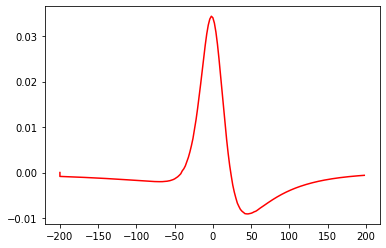

In [ ]:
plt.plot(xilist[:,0],xilist[:,1],'r')

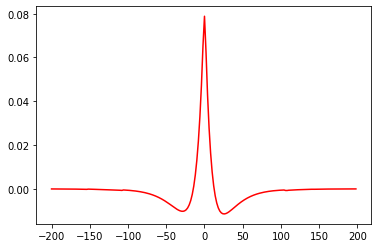

In [ ]:
plt.plot(delnbeqlist[:,0],delnbeqlist[:,1],'r')